<a href="https://colab.research.google.com/github/greygrease/tf-stuff/blob/main/Sentiment_Analysis_MultiModel_NN_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Helper Functions

In [12]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-27 06:19:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-27 06:19:47 (111 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [13]:
from helper_functions import unzip_data, create_tensorboard_callback,compare_historys, plot_loss_curves, calculate_results

## Download and Import Dataset

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/My Drive/kaggle_dataset'

In [16]:
%cd /content/gdrive/My Drive/kaggle_dataset

/content/gdrive/My Drive/kaggle_dataset


In [17]:
!kaggle datasets download -d kazanova/sentiment140

 93% 75.0M/80.9M [00:00<00:00, 143MB/s]
100% 80.9M/80.9M [00:00<00:00, 135MB/s]


In [18]:
!mkdir sentiment140_unpacked
!mv sentiment140.zip sentiment140_unpacked

In [19]:
%cd sentiment140_unpacked/

/content/gdrive/My Drive/kaggle_dataset/sentiment140_unpacked


In [20]:
!unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


## Create a pandas dataframe and preprocess the data



In [21]:
import pandas as pd

sentiment_df = pd.read_csv('/content/gdrive/MyDrive/kaggle_dataset/sentiment140_unpacked/training.1600000.processed.noemoticon.csv', encoding='latin-1')

In [22]:
sentiment_df = sentiment_df.drop(['Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY', '_TheSpecialOne_', '1467810369'], axis = 1)

In [23]:
sentiment_df.columns


Index(['0', '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'], dtype='object')

In [24]:
sentiment_df.rename(columns = {'0' : 'Label',
                               "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D" : 'Text'}, inplace = True)

In [25]:
sentiment_df.head()

,Label,Text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [26]:
first_col = sentiment_df.pop('Text')

In [27]:
sentiment_df.insert(0, 'Text', first_col)

In [28]:
sentiment_df.head()

,Text,Label
0,is upset that he can't update his Facebook by ...,0
1,@Kenichan I dived many times for the ball. Man...,0
2,my whole body feels itchy and like its on fire,0
3,"@nationwideclass no, it's not behaving at all....",0
4,@Kwesidei not the whole crew,0


In [29]:
sentiment_df = sentiment_df.sample(frac = 1, random_state = 42)

In [30]:
sentiment_df

,Text,Label
541200,@Nkluvr4eva My poor little dumpling In Holmde...,0
750,I'm off too bed. I gotta wake up hella early t...,0
766711,I havent been able to listen to it yet My spe...,0
285055,now remembers why solving a relatively big equ...,0
705995,"Ate too much, feel sick",0
...,...,...
259178,I didn't. The link was wrong,0
1414414,@tommcfly yes!! mcfly twitter profile is an ex...,4
131932,@SarahFTW I know sometimes i just pretend i h...,0
671155,Cant believe you came and asked me that...,0


### Split data into `Train`, `Test` and `Validation`

### Split DataFrame to `trainval` and `test`

In [31]:
from sklearn.model_selection import train_test_split

trainval_sentences, test_sentences, trainval_labels, test_labels = train_test_split(sentiment_df['Text'].to_numpy(),
                                                                                    sentiment_df['Label'].to_numpy(),
                                                                                    test_size = 0.15,
                                                                                    random_state = 42)

### Split `trainval` to `train` and `validation`

In [32]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(trainval_sentences,
                                                                            trainval_labels,
                                                                            test_size = 0.15,
                                                                            random_state = 42)

In [33]:
len(train_sentences), len(train_labels)

(1155999, 1155999)

In [34]:
len(test_sentences), len(test_labels)

(240000, 240000)

In [35]:
len(val_sentences), len(val_labels)

(204000, 204000)

## Visualize our dataset

In [36]:
import random
rand_id = random.randint(0, len(sentiment_df)-10)
for row in sentiment_df[['Text', 'Label']][rand_id : rand_id + 10].itertuples():
  _, text, target = row
  print(f'Target : {target}', '[Positive]' if target ==  4 else '[Negative]')
  print(f'Text : {text}')
  print(f'-----\n')

Target : 0 [Negative]
Text : @GMMR I know!! I'm loving it - I really missed it &amp; am so bummed that it's soon to be completely over. 
-----

Target : 0 [Negative]
Text : @A_Lay aww well I just randomly woke up and now I can't sleep! Too many things on my mind 
-----

Target : 4 [Positive]
Text : @ijustine psstt,...your new vids title is missing a &quot;T&quot; 
-----

Target : 4 [Positive]
Text : i will take a nap............... 
-----

Target : 4 [Positive]
Text : @oinettahunt - Awe. That's so sweet. I know @vincenthunt liked that.  
-----

Target : 4 [Positive]
Text : @LaraK the online ID calculator is a really cool tool....thanks for sharing! 
-----

Target : 4 [Positive]
Text : @tommcfly well god morning tom! 
-----

Target : 0 [Negative]
Text : @Uk_joedan_fan  OMG i hope it's not true, they cant go yet 
-----

Target : 0 [Negative]
Text : @YasmineGalenorn I used to work for n airline rerouting passengers. The airline industry is a royal disaster! Sorry she's stuck. 
-----

Targ

### Converting `train`, `val`, `test` dataframes into datasets

In [37]:
frames_train = [pd.DataFrame(train_sentences), pd.DataFrame(train_labels)]
frames_val = [pd.DataFrame(val_sentences), pd.DataFrame(val_labels)]
frames_test = [pd.DataFrame(test_sentences), pd.DataFrame(test_labels)]

train_df = pd.concat(frames_train, axis = 1)
val_df = pd.concat(frames_val, axis = 1)
test_df = pd.concat(frames_test, axis = 1)

train_df.columns = ['Text', 'Label']
val_df.columns = ['Text', 'Label']
test_df.columns = ['Text', 'Label']

In [38]:
train_df.Label.value_counts()

4    578220
0    577779
Name: Label, dtype: int64

## Model_0 Getting a Baseline


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create the model
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the model
model_0.fit(X = train_sentences,
            y = train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [40]:
# Evaluate our Baseline Model
model_0.score(X = val_sentences,
              y = val_labels)

0.7705245098039216

In [41]:
baseline_preds = model_0.predict(val_sentences)

In [42]:
baseline_results = calculate_results(y_true = val_labels,
                                     y_pred = baseline_preds)

In [43]:
RESULTS = {}
RESULTS['model_0'] = baseline_results

## Preparing data for Deep Sequence models

### Create Text Vectorizing and Embedding Layers

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [45]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]

In [46]:
sent_lens[:10]

[26, 10, 5, 11, 18, 17, 5, 19, 26, 15]

In [47]:
average_sent_lens = np.mean(sent_lens)
average_sent_lens

13.174920566540283

(array([4.3110e+03, 1.8171e+04, 3.7588e+04, 4.9260e+04, 5.8573e+04,
        6.2983e+04, 6.4575e+04, 6.4328e+04, 6.2677e+04, 6.0320e+04,
        5.8087e+04, 5.4993e+04, 5.1852e+04, 4.8882e+04, 4.5791e+04,
        4.3271e+04, 4.0543e+04, 3.8841e+04, 3.7516e+04, 0.0000e+00,
        3.7210e+04, 3.4925e+04, 3.4475e+04, 3.2906e+04, 3.0753e+04,
        2.7020e+04, 2.1461e+04, 1.5368e+04, 9.6030e+03, 5.3220e+03,
        2.6050e+03, 1.1210e+03, 4.2000e+02, 1.6000e+02, 5.7000e+01,
        1.4000e+01, 5.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  , 20.95, 21.9

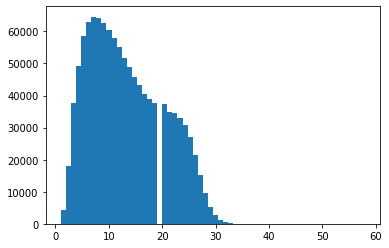

In [48]:
import matplotlib.pyplot as plt

plt.hist(sent_lens, bins = 60)

In [49]:
output_seq_len = int(np.percentile(sent_lens, 98))
output_seq_len

27

### Create Text Vectorizer Layer

In [86]:
max_vocab_length = 90000

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = max_vocab_length,
                                                    output_sequence_length = output_seq_len)

In [87]:
# Adapt text vectorizer to train sentence

text_vectorizer.adapt(train_sentences)

In [88]:
# Test vectorizing layer

import random
target_sent = random.choice(train_sentences)
print(f'Target Sentence:\n {target_sent}')
print(f'Length of text: {len(target_sent)}')
print(f'After Vectorizing:\n {text_vectorizer([target_sent])}')

Target Sentence:
 @BastetAsshur  WELCOME, following you too!! 
Length of text: 44
After Vectorizing:
 [[82934   380   413     8    45     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]]


In [89]:
# Most common and Least common words in our vocab

vocab_sentiment140 = text_vectorizer.get_vocabulary()
print(f'No of words in our Vocab: {len(vocab_sentiment140)}')
print(f'Most common words in Vocab: {vocab_sentiment140[:5]}')
print(f'Least common words in Vocab: {vocab_sentiment140[-20:]}')

No of words in our Vocab: 90000
Most common words in Vocab: ['', '[UNK]', 'i', 'to', 'the']
Least common words in Vocab: ['steelkey', 'steelersnm1', 'steeffie', 'steeeve', 'stealthy', 'stealthtricia', 'stealthbravo', 'stc', 'stbalkcom', 'stb', 'stayy', 'staybr00tal', 'stayathome', 'staxx', 'stawpitemily', 'stawberry', 'stavmcfly', 'stavanger', 'staunch', 'stau']


### Create Text Embedding Layer

In [90]:
token_embed = layers.Embedding(input_dim = len(vocab_sentiment140),
                               output_dim = 128,
                               mask_zero = True,
                               name = 'token_embedding')


In [91]:
# Test embedding layer

print(f'Before Vectorisation :\n {target_sent}\n')
vectorized_sent = text_vectorizer(target_sent)
print(f'After Vectorizing:\n {vectorized_sent}\n')
print(f'After Embedding:\n {token_embed(vectorized_sent)}')

Before Vectorisation :
 @BastetAsshur  WELCOME, following you too!! 

After Vectorizing:
 [82934   380   413     8    45     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]

After Embedding:
 [[-0.01525552  0.01288776 -0.00666648 ... -0.0277179  -0.03568234
  -0.03158122]
 [-0.00625547  0.01410255  0.01113534 ... -0.01855037 -0.01886336
  -0.02210816]
 [ 0.00580243  0.01783855 -0.04835502 ...  0.02586608 -0.03387487
   0.00030332]
 ...
 [ 0.00305556 -0.04094525 -0.01847034 ... -0.04311564 -0.01578224
   0.00334188]
 [ 0.00305556 -0.04094525 -0.01847034 ... -0.04311564 -0.01578224
   0.00334188]
 [ 0.00305556 -0.04094525 -0.01847034 ... -0.04311564 -0.01578224
   0.00334188]]


## Creating Datasets for faster processing


In [92]:
# Turn datasets into prefetched
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, tf.one_hot(train_labels,depth = 1))).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, tf.one_hot(test_labels, depth = 1))).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, tf.one_hot(val_labels, depth = 1))).batch(32).prefetch(tf.data.AUTOTUNE)

## Model_1: Conv1D + Embedding

In [114]:
# Create the model
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)),
                              callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss')])

Epoch 1/3
3612/3612 [==============================] - 38s 10ms/step - loss: 0.4841 - accuracy: 0.7746 - val_loss: 0.4711 - val_accuracy: 0.7880
Epoch 2/3
3612/3612 [==============================] - 36s 10ms/step - loss: 0.4535 - accuracy: 0.7936 - val_loss: 0.4525 - val_accuracy: 0.7947


In [115]:
model_1.evaluate(val_dataset)

6375/6375 [==============================] - 17s 3ms/step - loss: 0.4471 - accuracy: 0.7976


[0.4471026659011841, 0.7975833415985107]

In [116]:
model_1_pred_probs = model_1.predict(val_sentences)

In [117]:
model_1_preds = np.round(model_1_pred_probs)

In [118]:
model_1_results = calculate_results(y_true = tf.one_hot(val_labels, depth = 1),
                                    y_pred = model_1_preds)

In [122]:
np.round(model_1.predict(['the engine is too loud']))

array([[0.]], dtype=float32)

In [120]:
model_1_results

{'accuracy': 79.75833333333333,
 'precision': 0.7979548276198306,
 'recall': 0.7975833333333333,
 'f1': 0.7975200318654385}

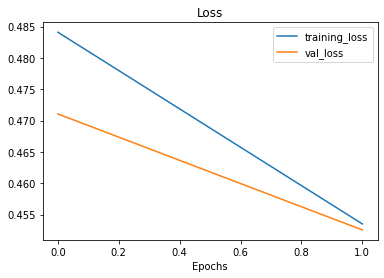

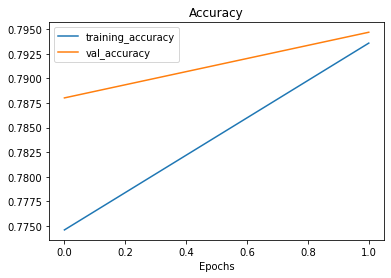

In [121]:
plot_loss_curves(model_1_history)